# EDS Simulation
In this example/tutorial we want to elaborated on enveloping distribution sampling (EDS) and how it can be used to calculate relative free energies.


Content:
 * Constructing the reference state
 * Sampling the reference state
 * Calculating the free energies
 
 

In [1]:
#if package is not installed:
import os, sys
my_path = os.getcwd()+"/.."
print(my_path)
sys.path.append(my_path)

#Imports:
import numpy as np
from matplotlib import pylab as plt

#import Ensembler
from ensembler.potentials import OneD as pot

##Imports:
import ensembler.visualisation.plotPotentials as exPlot
%pylab inline


C:\Users\benja\OneDrive - ETH Zürich\PhD\Code\ensembler_public\examples/..
Populating the interactive namespace from numpy and matplotlib


C:\Users\benja\anaconda3\envs\EnsemblerDev\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The Problem
For our EDS Tutorial we assume that we have a two atom molecule with one bond.
We want to know what happens if this bond is changing to another bond type.

The two bond types will be modelled as harmonic oscillators according to hooke's law:

$V_i(r) = 0.5 k_i (r - r_{0_i})^2 + V_{offset_i}$

With:
 * $V_{offset_i}$ as the shift of the minimal energy of Bond type i
 * $k_i$ as the force constant of Bond type i
 * $r_{0_i}$ the optimal length of Bond type i

A bond type change translates to a change in optimal length, a different minimum energy and a different force constant. 

We are interested in two particular bond types A and B, which are defined as follows:


(0, 5)

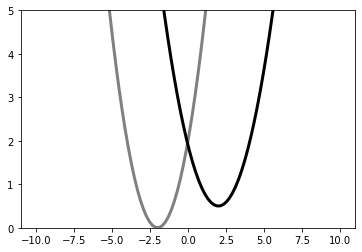

In [2]:
test_timing_with_points=100
positions = np.linspace(-10, 10, test_timing_with_points)

V_offset_A = 0
r_0_A = -2
k_A = 1

V_offset_B = 0.5
r_0_B = 2
k_B = 0.7

V_A = pot.harmonicOscillatorPotential(x_shift=r_0_A, y_shift=V_offset_A, k=k_A)
V_B = pot.harmonicOscillatorPotential(x_shift=r_0_B, y_shift=V_offset_B, k=k_B)

fig,ax = plt.subplots(ncols=1)
ax.plot(positions, V_A.ene(positions), c="grey", lw=3, zorder=-1, label="$V_A$")
ax.plot(positions, V_B.ene(positions), c="black", lw=3, zorder=-1, label="$V_B$")
ax.set_ylim([0,5])

## The Reference Potential
The method EDS is building in its first step a Reference Potential $V_R$, leading to the reference state R enveloping all endstates of interest.


### Building an EDS Potential
To build our $V_R$, one needs to construct:

$V_R(r, s, E^R) = \frac{-1}{\beta s} \ln(e^{-\beta s (V_A(r) - E^R_A)}+e^{-\beta s (V_B(r) - E^R_B)})$

With:
 * $s$ as the smoothing parameter
 * $E^R$ as the energy offset vector

Which is done in the following:

V_R of our system:
  -log(Sum(exp(-Matrix([
[ 0.5*r**2 + 2.0*r + 2.0],
[0.35*r**2 - 1.4*r + 1.9]])[i, 0]), (i, 0, 1)))/s_i

calculate 100 positions - time check
Wall time: 118 ms

Visualization


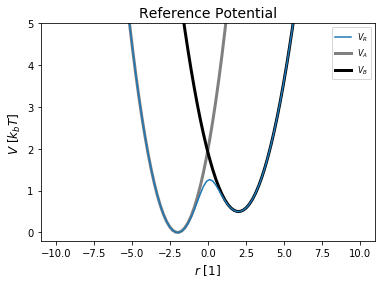

In [3]:

V_R = pot.envelopedPotential(V_is=[V_A,V_B], s=1, eoff=[0,0])
print("V_R of our system:\n ", V_R.V)

print("\ncalculate "+str(len(positions))+" positions - time check")
%time V_R.ene(positions)

print("\nVisualization")
#Plotting
fig,ax = plt.subplots(ncols=1)
ax.plot(positions, V_R.ene(positions), label="$V_R$")
ax.plot(positions, V_A.ene(positions), c="grey", lw=3, zorder=-1, label="$V_A$")
ax.plot(positions, V_B.ene(positions), c="black", lw=3, zorder=-1, label="$V_B$")
ax.set_ylim([-0.2,5])
ax.set_ylabel("$V~[k_b T]$ ")
ax.set_xlabel("$r~[1]$ ")
ax.set_title("Reference Potential")
ax.legend()

Note that both potentials are enveloped by $V_R$ and that all minimas are preserved.

### What are the parameters for in EDS?

#### $E^R$ -  Energy Offsets

With the energy  offsets the different states minimas can be aligned to each other.  
This is of important if the reference potential is sampled as better aligned potentials allow better sampling of all states. We will see this later in the sampling section.

But how do we get good energy offsets?
A problem with the energy offsets is, that they are actually very close to the final resulting dG.
Therefore we have a hen-egg problem. 
Usually one uses a cheaper technique to estimate the free energy offsets and uses these less accurate estimates to calculate a better one.


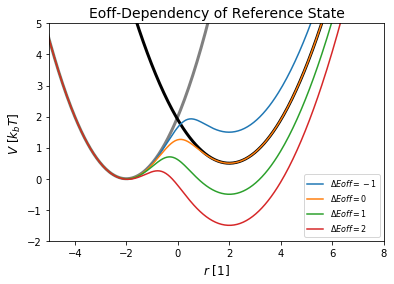

In [4]:
##Construct potential
s=1
Eoffs=[(0, -1), (0, 0), (0, 1), (0, 2)]

##Parameters
svals= np.logspace(0,-0.5, num=5) 
positions = np.linspace(-10,10, 500)

##Plot
fig,ax = plt.subplots(ncols=1)
ax.plot(positions, V_A.ene(positions), c="grey", lw=3, zorder=-1)
ax.plot(positions, V_B.ene(positions), c="black", lw=3, zorder=-1)

for eoff in Eoffs:
    V_R.Eoff = eoff
    ax.plot(positions, V_R.ene(positions), label="$\Delta Eoff="+str(eoff[1])+"$")
    
ax.set_ylim([-2,5])
ax.set_xlim([-5,8])

ax.set_title("Eoff-Dependency of Reference State")
ax.set_ylabel("$V~[k_b T]$ ")
ax.set_xlabel("$r~[1]$ ")
ax.legend()

V_R.Eoff = (0,0)

#### $s$ Smoothing Parameter

The smoothing parameter s is used to lower the barriers between the different states (here A and B).

We usually consider $s~=~1$ as a physical resonable s-value. Values higher than $s~=~1$ are raising the barrier between the two states, until they converge to the state intersection.

The more interesting s-values are between $0$ and $1$. 
These values are lowering the barrier between the states till a certain optimal s value.
If the s-value is passed, lower s-values lead to a global minimum called undersampling. 
Undersampling is an artificial state that is not a good state for sampling physical reasonable coordinates for all states.

Therefore one must find a feasible s-value to sample all states optimally.

Bonus: negative s-values lead to an reference state only covering the overlap of the different states. You can try it out if you dare. ;)

 


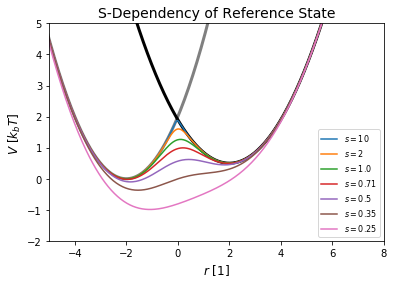

In [5]:
##Construct potential
s=1
Eoffs=(0, 0)

##Parameters
svals= [ 10,2]+list(np.logspace(0,-0.6, num=5))

##Plot
fig,ax = plt.subplots(ncols=1)
ax.plot(positions, V_A.ene(positions), c="grey", lw=3, zorder=-1)
ax.plot(positions, V_B.ene(positions), c="black", lw=3, zorder=-1)

for s in svals:
    V_R.s = s
    ax.plot(positions, V_R.ene(positions), label="$s= "+str(np.round(s,2))+"$")
    
ax.set_ylim([-2,5])
ax.set_xlim([-5,8])

ax.set_title("S-Dependency of Reference State")
ax.set_ylabel("$V~[k_b T]$ ")
ax.set_xlabel("$r~[1]$ ")
ax.legend()

V_R.s = 1.0

### interactive example
Here you can play around with the reference state of multiple harmonic oscillators and the parameters.

Sometimes the cell below must be executed multiple times to work properly.

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


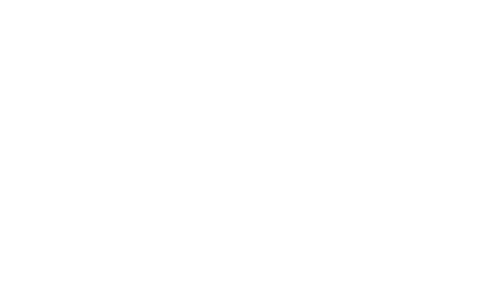

<IPython.core.display.Javascript object>


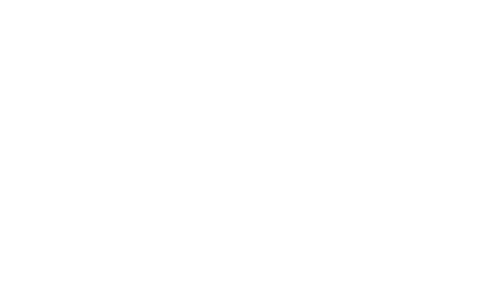

In [6]:
from ensembler.visualisation.interactive_plots import interactive_eds

%pylab notebook
app = interactive_eds()


### Bonus: s-optimization now many potentials == Art


Populating the interactive namespace from numpy and matplotlib


(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21a29895248>)

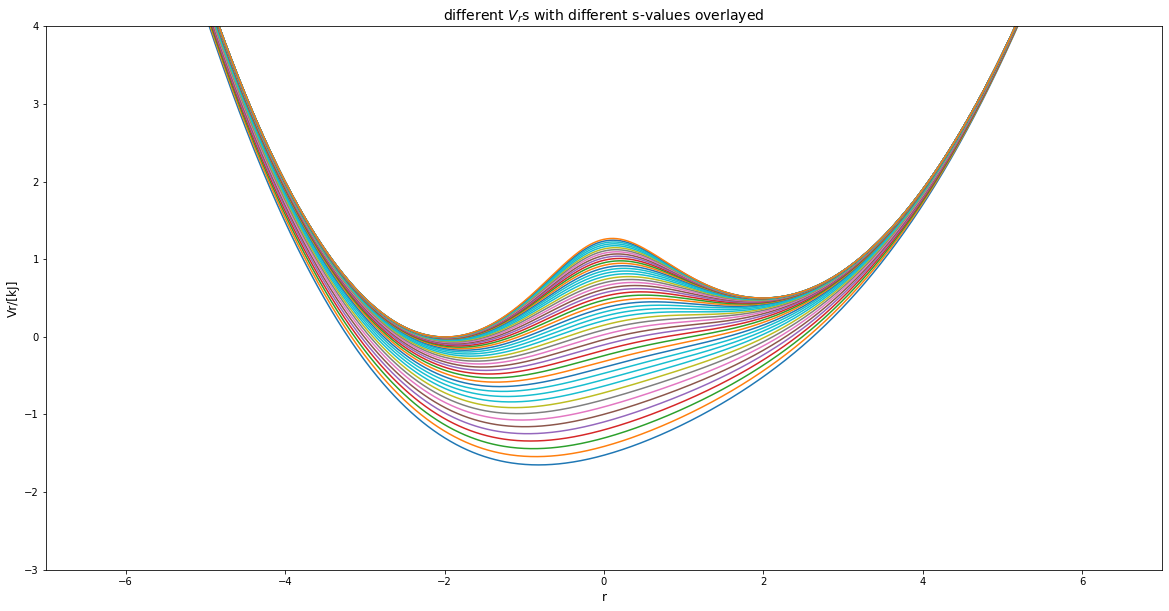

In [7]:
%pylab inline

svals= np.logspace(0, -0.7,num=50)
positions=np.linspace(-7,7,1000)
exPlot.envPot_differentS_overlay_plot(eds_potential=V_R, s_values=svals, positions=positions,
                                           hide_legend=True, y_range=(-3, 4))

## Sampling the Enveloping Potential
Up to now we defined the reference state potential. 
But now let's assume we don't know how the potential looks like. This is often the case in molecular simulations, each molecule can be described by a function, but the coordinate space of the molecule might be so huge, that we can not calculate all solutions. 

That's why we usually sample such potential functions in the hope of getting the relevant solutions for the relevant conformers of a molecule.

In the following we will simulate the constructed reference state potential for a number so simulation steps with the metropolis monte carlo method.

We are going to check on how the simulations are going to behave depending on the given parameter sets.
Following the system to simulate will be defined.

In [8]:
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator
from ensembler.system import system
from ensembler.visualisation.plotSimulations import simulation_analysis_plot

%pylab inline


#Simulation Setup
##simulation parameters:
simulation_steps = 1000
temperature = 10
start_position = -2

##set initial parameters of Reference state:
V_R.Eoff = (0,0)
V_R.s = 1

##Sampling Method:
sampler = metropolisMonteCarloIntegrator(step_size_coefficient=1, 
                                         max_iteration_tillAccept=100)

##System:
EDS_system = system(potential=V_R, 
                    sampler=sampler, temperature=temperature,
                    start_position=start_position)

Populating the interactive namespace from numpy and matplotlib


#### First Simulation
after building the system, that functions as a wrapper between sampling method and potential function, we are finally about to simulate the system.

In [9]:
EDS_system.simulate(simulation_steps, withdraw_traj=True)
orgi_eds_traj = EDS_system.trajectory
EDS_system.trajectory.head()


Simulation:  Simulation: 100%|██████████| 1000/1000 [00:06<00:00, 144.07it/s]


,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,-2,10,-0.002240,-0.002240,NaN,0.006265975859573731,NaN
1,-1.8892208222224074,10,0.003077,0.003077,NaN,0.11077917777759272,NaN
2,-1.9379866424727308,10,-0.000743,-0.000743,NaN,-0.04876582025032339,NaN
3,-2.4947722381083346,10,0.121818,0.121818,NaN,-0.5567855956356038,NaN
4,-2.396362916405697,10,0.077795,0.077795,NaN,0.09840932170263783,NaN


Here you see the first lines of the generated trajectory of our simulation. Let's visualize that:

[-2, 2]


(<Figure size 1152x288 with 3 Axes>, None)

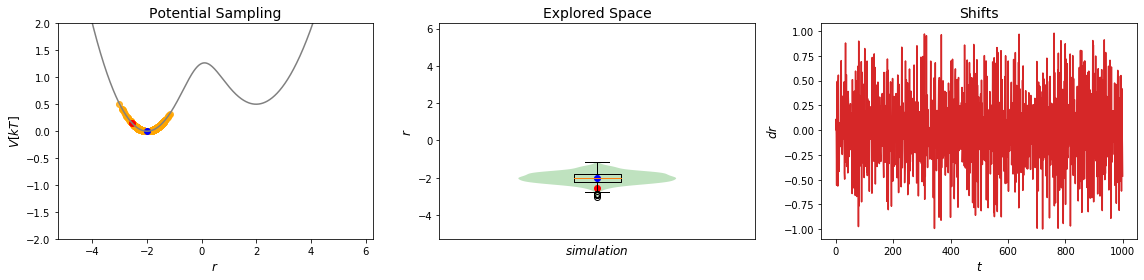

In [10]:
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], 
                         oneD_limits_potential_system_energy=[-2,2])

In the cell above you see the simulation analysis plot.
Most likely, as you can se in the Potential Sampling panel, the simulation with the initiall parameters was stuck in the minima of state A the whole time (blue point is the starting coordinate, red point the ending coordinate). 
This leads to a single normal distribution around coordinate -2 as you can see in the second panel.

This leads to a very nice sampling of state A but we never saw the minimum of state B. 
As a result the estimated free energies will not lead to a good free energy estimation.

The third panel shows you what the different shift sizes are during the simulation.


Note: You can execute the simulation multiple times and will end up with always slightly different results.

### How do the parameters affect sampling?

Can we fix this problem?
Let's have a look on how the paramteres mentioned in the reference potential change the sampling.

### s-dependency:

Here we want to have a look on how the sampling is influenced by different s-values and their barrier removal capacity.


Simulation:  Simulation:   0%|          | 0/1000 [00:00<?, ?it/s]

[-3, 2]


Simulation:  Simulation: 100%|██████████| 1000/1000 [00:06<00:00, 160.02it/s]


[-3, 2]


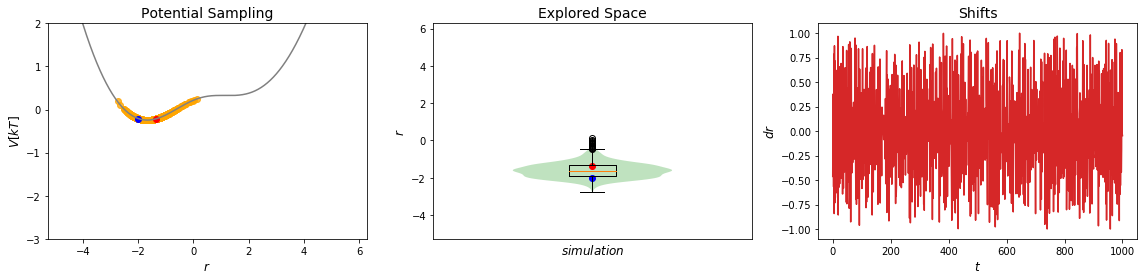

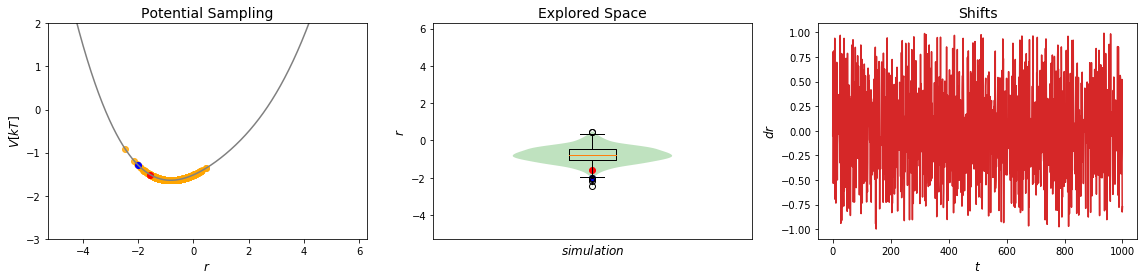

In [11]:
EDS_system.potential.Eoff=(0, 0) #set initial parameters

# a lower s value
EDS_system.potential.s=0.4
EDS_system.set_position(-2) # same starting position
EDS_system.simulate(simulation_steps, withdraw_traj=True)
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], oneD_limits_potential_system_energy=[-3,2])

# an even lower s value
EDS_system.potential.s=0.2
EDS_system.set_position(-2) # same starting position
EDS_system.simulate(simulation_steps, withdraw_traj=True)
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], oneD_limits_potential_system_energy=[-3,2])
undersampling_eds_traj = EDS_system.trajectory


This is an interesting finding.
The barriers between the states gets smoothed out, but we also lose the minimum of state B.
For an $s~=~0.7$ we clearly see that the barrier is shrinking, but as the bond type B has a higher minimal potential energy, we can still not reach the state during the short simulation. 

In the second case with $s~=~0.2$ we are an undersampling situation. 
Here we explore a conformational space close to state A. 
The minimum of state B is lost totally in this case.

Conclusion: During our simulations we still do not manage to reach both state minima. But what happens if we also change Eoff?

### Eoff-dependency:

Now we want to combine our findings from the s-dependency with the energy offset parameters.


Simulation:  Simulation:   0%|          | 0/1000 [00:00<?, ?it/s]

[-3, 2]


Simulation:  Simulation:   0%|          | 0/1000 [00:00<?, ?it/s]

[-3, 2]


Simulation:  Simulation: 100%|██████████| 1000/1000 [00:06<00:00, 164.61it/s]


[-3, 2]


(<Figure size 1152x288 with 3 Axes>, None)

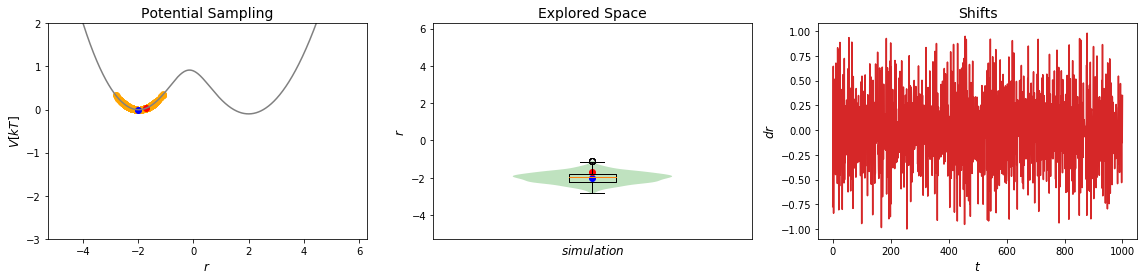

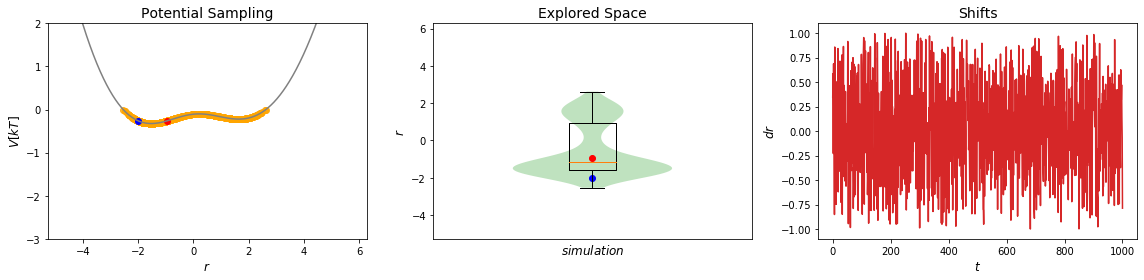

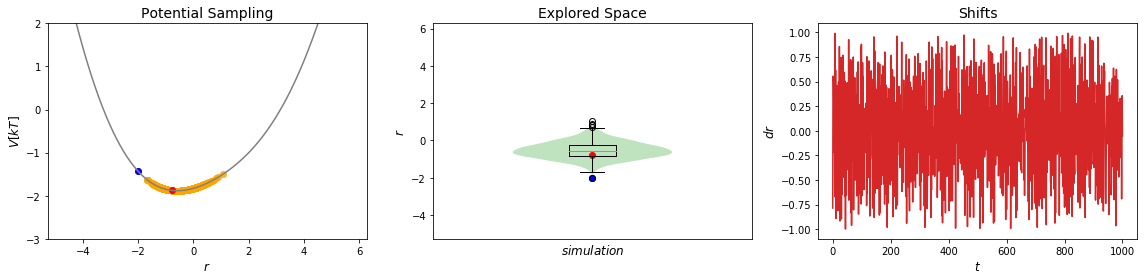

In [12]:
EDS_system.potential.Eoff=(0, 0.6)

EDS_system.potential.s=1
EDS_system.set_position(-2) # same starting position
EDS_system.simulate(simulation_steps, withdraw_traj=True)
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], oneD_limits_potential_system_energy=[-3,2])

EDS_system.potential.s=0.4
EDS_system.set_position(-2) # same starting position
EDS_system.simulate(simulation_steps, withdraw_traj=True)
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], oneD_limits_potential_system_energy=[-3,2])
optimal_eds_traj = EDS_system.trajectory

EDS_system.potential.s=0.2
EDS_system.set_position(-2) # same starting position
EDS_system.simulate(simulation_steps, withdraw_traj=True)
simulation_analysis_plot(EDS_system, limits_coordinate_space=[-5,5], oneD_limits_potential_system_energy=[-3,2])

## Calculating Free Energies With EDS

### Analytical solution to the problem
The nice thing about using harmonic oscillators for free energy calculations as toy-models is, that the correct solution can be calculated analytically!

$dG_i = y_{shift_i} - \frac{1}{2*\beta} * \ln(\sqrt{\frac{2*\pi}{k_i*\beta}}) $

This solution is here used as the reference for all further calculations.

In [18]:

#Excpected Analytical Solution
beta = 1/10 # beta is in k_B T

G_A = V_offset_A -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k_A*beta)))
G_B = V_offset_B -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k_B*beta)))
dG_expected = G_B-G_A

print("expected dG: ", dG_expected)


expected dG:  -0.3916873598468307


### Numerical solution to the problem
With our sampling we can now estimate the relative free energy of our two states.

In [19]:
from ensembler.analysis import freeEnergyCalculation as FE
fe_estimator = FE.dfEDS(kJ=True, T=10)

positions_orig_eds = orgi_eds_traj.position
Vrr_orig_eds = orgi_eds_traj.total_potential_energy
V1r_orig_eds = V_A.ene(positions_orig_eds)
V2r_orig_eds = V_B.ene(positions_orig_eds)

dF_original = fe_estimator.calculate(Vi=V1r_orig_eds, Vj=V2r_orig_eds, Vr=Vrr_orig_eds)

print("dG: ", dF_original," kJ", "\ndeviation: ", abs(dF_original-dG_expected)," kJ")

dG:  -4.224445543200067  kJ 
deviation:  3.8327581833532367  kJ


In [20]:

positions_undersampling_eds = undersampling_eds_traj.position
Vrr_undersampling_eds = undersampling_eds_traj.total_potential_energy
V1r_undersampling_eds = V_A.ene(positions_undersampling_eds)
V2r_undersampling_eds = V_B.ene(positions_undersampling_eds)

dF_undersampling = fe_estimator.calculate(Vi=V1r_undersampling_eds, Vj=V2r_undersampling_eds, Vr=Vrr_undersampling_eds)

print("dG: ", dF_undersampling," kJ", "\ndeviation: ", abs(dF_undersampling-dG_expected)," kJ")

dG:  -1.61453569889639  kJ 
deviation:  1.2228483390495593  kJ


In [21]:

positions_optimal_eds = optimal_eds_traj.position
Vrr_optimal_eds = optimal_eds_traj.total_potential_energy
V1r_optimal_eds = V_A.ene(positions_optimal_eds)
V2r_optimal_eds = V_B.ene(positions_optimal_eds)

dF_optimal = fe_estimator.calculate(Vi=V1r_optimal_eds, Vj=V2r_optimal_eds, Vr=Vrr_optimal_eds)

print("dG: ", dF_optimal," kJ", "\ndeviation: ", abs(dF_optimal-dG_expected)," kJ")

dG:  -0.4674482714216003  kJ 
deviation:  0.07576091157476961  kJ


Not that only the optimal sampling gives nice relative free energies with a low deviation towards the analytically calculated reference free energy.

## Many States

But is eds limited to two states?
No and that is where it's power comes into play. 
In theory one can calculate the relative free energies for many states from one simulation.

$V_R = \frac{-1}{\beta s} \ln(\sum_i^Ne^{-\beta s (V_i - E^R_i)})$

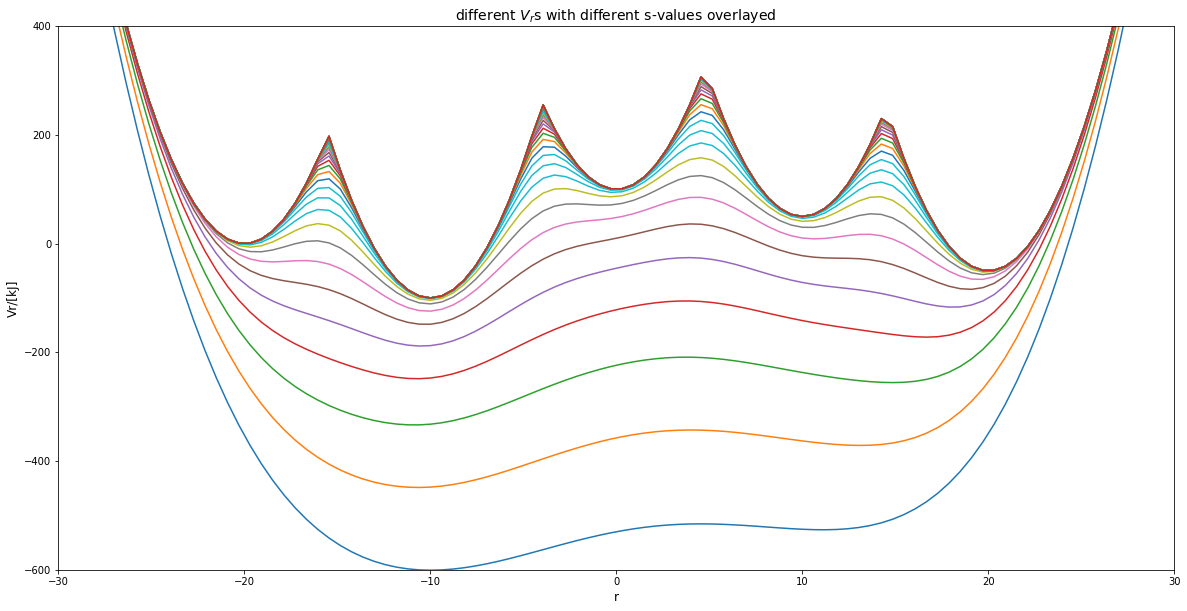

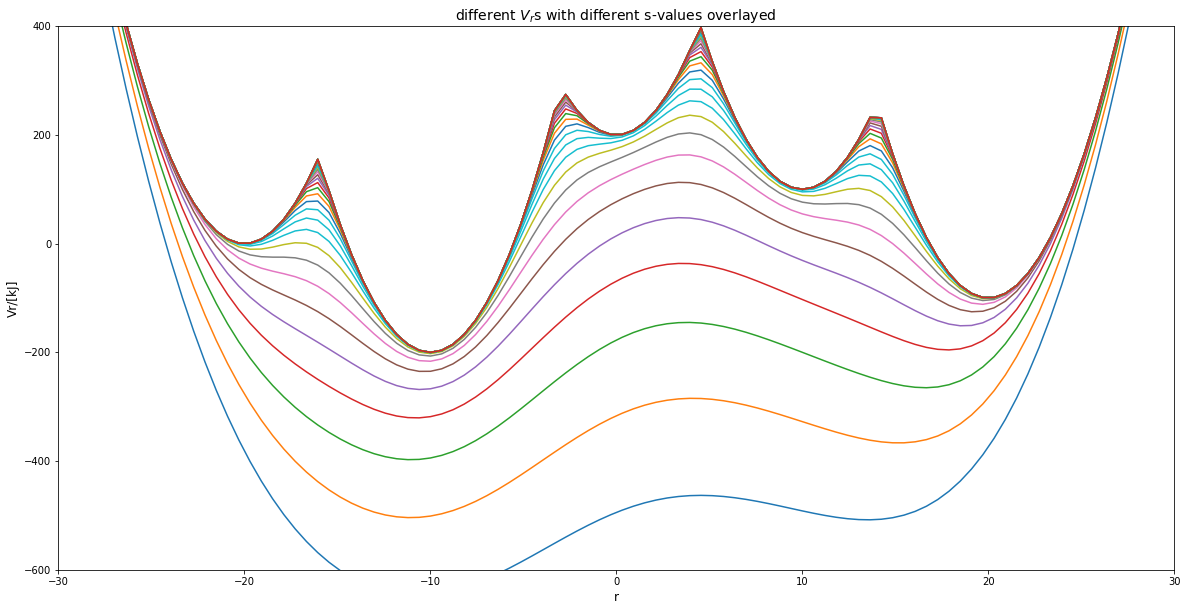

In [17]:
### SuperMore complex example - 3 states  harmonicPot - 
# simple Example plot Enveloped Potential with two Harmonic Oscilators


##Construct potential
s1=1.0
s2=0.001
Eoffs=(0, 0, 0, 0, 0)


#V_is=[pot.harmonicOsc1D(x_shift=-10, fc=5), pot.harmonicOsc1D(x_shift=10, fc=5)]
k=20
V_is=[pot.harmonicOscillatorPotential(x_shift=-20, k=k, y_shift=0), 
      pot.harmonicOscillatorPotential(x_shift=20, k=k, y_shift=-50),
      pot.harmonicOscillatorPotential(x_shift=10, k=k, y_shift=50), 
      pot.harmonicOscillatorPotential(x_shift=-10, k=k, y_shift=-100), 
      pot.harmonicOscillatorPotential(x_shift=0, k=k, y_shift=100)]
eds_pot = pot.envelopedPotential(V_is=V_is, s=s1, eoff=Eoffs)

##Parameters
positions = np.linspace(-30,30,100)
svals=np.logspace(0, -3, 40)

exPlot.envPot_differentS_overlay_plot(eds_potential=eds_pot, s_values=svals, positions=positions, 
                                           y_range=(-600,400), hide_legend=True)

Eoffs=(0, 50, -50, 100, -100)
eds_pot = pot.envelopedPotential(V_is=V_is, s=s1, eoff=Eoffs)
fig, ax = exPlot.envPot_differentS_overlay_plot(eds_potential=eds_pot, s_values=svals, positions=positions, 
                                           y_range=(-600,400), hide_legend=True)



Can you sample them all?

## Literature:
About EDS:
 * Christ 2007
 * Christ 2008

Going beyond EDS:
 * Sidler 2016
 * Sidler 2017